In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Colab Notebooks/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/assignment1/cs231n/datasets
/content/drive/My Drive/Colab Notebooks/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

图像特征练习
填写并提交此已完成的工作表（包括其输出和工作表外的任何支持代码）以及您的作业提交。有关更多详细信息，请参阅课程网站上的作业页面。

我们已经看到，通过在输入图像的像素上训练线性分类器，我们可以在图像分类任务上实现合理的性能。在本练习中，我们将展示，我们可以通过训练线性分类器来提高分类性能，不是在原始像素上，而是在从原始像素计算出的特征上。

你在这个练习中的所有工作都将在这个笔记本上完成。

In [4]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [5]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

提取特征
对于每幅图像，我们将使用HSV颜色空间中的色调通道计算一个方向梯度直方图（HOG）和一个颜色直方图。我们通过将HOG和颜色直方图特征向量连接起来，为每张图像形成最终的特征向量。

粗略地说，HOG应该在忽略颜色信息的情况下捕获图像的纹理，颜色直方图在忽略纹理的情况下表示输入图像的颜色。因此，我们预计两者结合使用应该比单独使用更好。为了你自己的利益，验证这个假设是一件好事。

hog_feature和color_histogram_hsv函数都对单个图像进行操作，并返回该图像的特征向量。extract_features函数获取一组图像和一系列特征函数，并对每张图像上的每个特征函数进行评估，将结果存储在矩阵中，其中每一列是单个图像的所有特征向量的连接。

In [6]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

基于特征训练SVM
使用任务中早期开发的多类SVM代码，在上述提取的特征之上训练SVM；这应该比直接在原始像素上训练SVM获得更好的结果。

In [7]:
# Use the validation set to tune the learning rate and regularization strength4
#使用验证集调整学习率和正则化强度

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
#使用验证集设置学习率和正则化强度#
#这应该与您对SVM所做的验证相同；保存#
#bestsvm中训练最好的分类器。你可能也想玩#
#在颜色直方图中具有不同数量的区间。如果你小心的话#
#您应该能够在验证集上获得接近0.44的准确度。
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for lr in learning_rates:
    for reg in regularization_strengths:
        svm=LinearSVM()
        svm.train(X_train_feats,y_train,learning_rate=lr,reg=reg,num_iters=1000,verbose=True)
        y_train_pred=svm.predict(X_train_feats)
        train_accuracy=np.mean(y_train==y_train_pred)
        y_val_pred=svm.predict(X_val_feats)
        val_accuracy=np.mean(y_val==y_val_pred)
        results[(lr,reg)]=(train_accuracy,val_accuracy)
        if val_accuracy>best_val:
            best_val=val_accuracy
            best_svm=svm
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE




# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

iteration 0 / 1000: loss 84.688287
iteration 100 / 1000: loss 83.183580
iteration 200 / 1000: loss 81.730730
iteration 300 / 1000: loss 80.298531
iteration 400 / 1000: loss 78.870788
iteration 500 / 1000: loss 77.500193
iteration 600 / 1000: loss 76.138833
iteration 700 / 1000: loss 74.821711
iteration 800 / 1000: loss 73.500210
iteration 900 / 1000: loss 72.235079
iteration 0 / 1000: loss 765.838456
iteration 100 / 1000: loss 628.574241
iteration 200 / 1000: loss 516.217342
iteration 300 / 1000: loss 424.233689
iteration 400 / 1000: loss 348.932144
iteration 500 / 1000: loss 287.285150
iteration 600 / 1000: loss 236.811385
iteration 700 / 1000: loss 195.499700
iteration 800 / 1000: loss 161.674139
iteration 900 / 1000: loss 133.989942
iteration 0 / 1000: loss 7853.210592
iteration 100 / 1000: loss 1059.966063
iteration 200 / 1000: loss 149.809908
iteration 300 / 1000: loss 27.865400
iteration 400 / 1000: loss 11.527518
iteration 500 / 1000: loss 9.338624
iteration 600 / 1000: loss 9.0

In [8]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.423


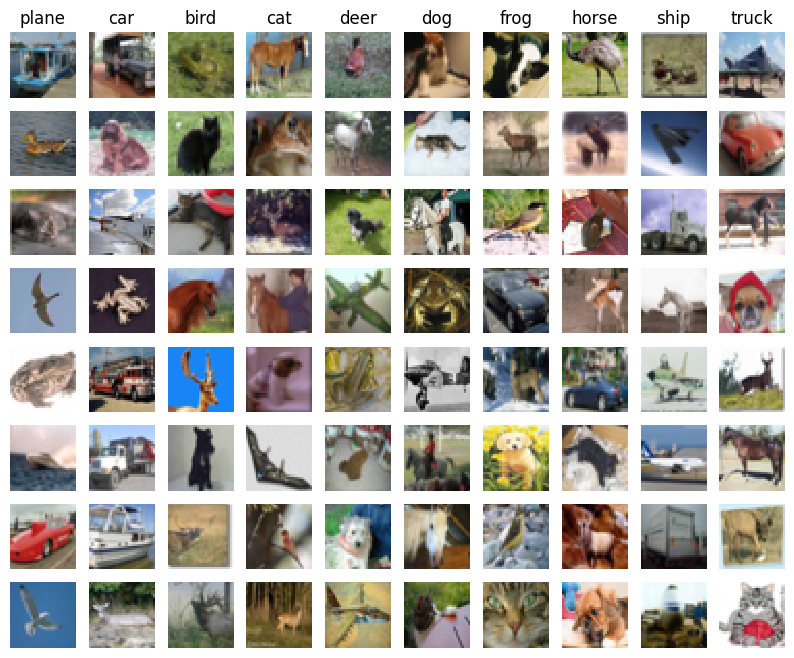

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".
#了解算法工作原理的一个重要方法是
#想象一下它所犯的错误。在这个可视化中，我们展示了示例
#我们目前的系统对图像进行了错误分类。第一列
#显示了我们的系统标记为“平面”的图像，但其真正的标签是
#除了“飞机”之外。

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$

描述你看到的错误分类结果。它们有意义吗？
分类基本错误 只有少部分正确 有意义


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

基于图像特征的神经网络
在本次分配的早期，我们看到在原始像素上训练一个两层神经网络比在原始像素下训练线性分类器具有更好的分类性能。在本笔记本中，我们看到图像特征的线性分类器优于原始像素的线性分类器。

为了完整起见，我们还应该尝试在图像特征上训练神经网络。这种方法应该优于所有以前的方法：你应该很容易在测试集上达到55%以上的分类准确率；我们的最佳模型实现了约60%的分类准确率。

In [10]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [14]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_val_acc = 0
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.
#TODO：在图像特征上训练一个两层神经网络。你可能想#
#如前几节所述，交叉验证各种参数。储存你最好的#
#bestnet变量中的模型。             #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
learning_rate=[1e-1,1e-2,1e-3]
batch_size=[50,100,200,400]
for j in learning_rate:
  for k in batch_size:
    solver=Solver(net,data,
          update_rule='sgd',
          optim_config=
          {
          'learning_rate':j,
          },
          lr_decay=0.95,
          num_epochs=5,
          batch_size=k,
          print_every=100)
    solver.train()
    val_acc = solver.val_acc_history[-1]
    if val_acc > best_val_acc:
      best_val_acc = val_acc
      best_net = net
      print(f"val_acc={val_acc},best_val_acc={best_val_acc}")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


(Iteration 1 / 4900) loss: 2.302579
(Epoch 0 / 5) train acc: 0.112000; val_acc: 0.095000
(Iteration 101 / 4900) loss: 2.259553
(Iteration 201 / 4900) loss: 1.655880
(Iteration 301 / 4900) loss: 1.597116
(Iteration 401 / 4900) loss: 1.311360
(Iteration 501 / 4900) loss: 1.471394
(Iteration 601 / 4900) loss: 1.494616
(Iteration 701 / 4900) loss: 1.103766
(Iteration 801 / 4900) loss: 1.128674
(Iteration 901 / 4900) loss: 1.185032
(Epoch 1 / 5) train acc: 0.523000; val_acc: 0.515000
(Iteration 1001 / 4900) loss: 1.155201
(Iteration 1101 / 4900) loss: 1.287448
(Iteration 1201 / 4900) loss: 1.278176
(Iteration 1301 / 4900) loss: 1.393263
(Iteration 1401 / 4900) loss: 1.039072
(Iteration 1501 / 4900) loss: 1.210543
(Iteration 1601 / 4900) loss: 1.212462
(Iteration 1701 / 4900) loss: 1.218148
(Iteration 1801 / 4900) loss: 1.318085
(Iteration 1901 / 4900) loss: 1.178405
(Epoch 2 / 5) train acc: 0.564000; val_acc: 0.546000
(Iteration 2001 / 4900) loss: 1.083191
(Iteration 2101 / 4900) loss: 0.82

In [15]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.
#在测试集上运行你最好的神经网络分类器。你应该能够
#准确率超过55%。

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.589
